In [46]:
# move to the folder
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Ifeanyi/classify_profile_pictures

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Ifeanyi/classify_profile_pictures


The TensorFlow Lite Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

### Prerequisite

we first need to install several required packages, including Model Maker package that is in this GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [49]:
#!pip install -q tflite-model-maker

     |████████████████████████████████| 593kB 3.5MB/s 
     |████████████████████████████████| 215kB 37.9MB/s 
     |████████████████████████████████| 6.3MB 35.6MB/s 
     |████████████████████████████████| 849kB 52.3MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 1.2MB 26.1MB/s 
     |████████████████████████████████| 122kB 51.4MB/s 
     |████████████████████████████████| 645kB 45.0MB/s 
     |████████████████████████████████| 686kB 53.2MB/s 
     |████████████████████████████████| 1.1MB 43.2MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 358kB 53.3MB/s 
     |████████████████████████████████| 37.2MB 75kB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 204kB 38.2MB/s 


Import the required packages.

In [50]:
# Import required packages
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import image_classifier
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

### Get the data path
The data needs to be arranged in an order whereby all images that belongs to a particular class are stored in a subdirectory and a single parent directory holds all subdirectories.
The names of the subdirectories are used as the data labels

In [51]:
import pathlib
image_path = pathlib.Path('./images/')

Use DataLoader class to load data.

As for from_folder() method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.


Split it to training data (91%), and testing data (9%), from 1,100 images

In [52]:
data = DataLoader.from_folder(image_path)
train_data, test_data = data.split(0.91)

INFO:tensorflow:Load image with size: 220, num_label: 2, labels: asian_americans, black_americans.


Show 25 image examples with labels.

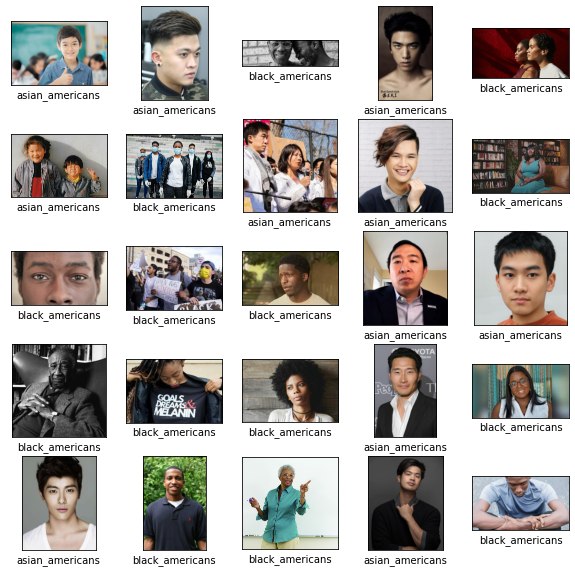

In [53]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

# Step 2: Customize the TensorFlow Model
Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0. The model is trained for 50 epochs

In [54]:
model = image_classifier.create(train_data, validation_data=test_data, epochs=50)

INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
6/6 [==============================] - 14s 2s/step - loss: 0.7646 - accuracy: 0.5104
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.5936 - accuracy: 0.6823
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.4463 - accuracy: 0.8490
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.3937 - accuracy: 0.8750
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 0.3682 - accuracy: 0.9062
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 0.3426 - accuracy: 0.9375
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 0.3233 - accuracy: 0.9323
Epoch 8/50
6/6 [==============================] - 11s 2s/step - loss: 0.3141 - accuracy: 0.9531
Epoch 9/50
6/6 [==============================] - 11s 2s/step - loss: 0.3096 - accuracy: 0.9740
Epoch 10/50
6/6 [==============================] - 11s 2s/step - loss: 0.2821 - accuracy: 0.9844
Epoch 11/50
6/6 [======================

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


# Step 3: Evaluate the Customized Model
Evaluate the result of the model on the test set, get the loss and accuracy of the model.

In [56]:
loss, accuracy = model.evaluate(test_data)

1/1 [==============================] - 3s 3s/step - loss: 0.3522 - accuracy: 0.9000


# Step 4: Export to TensorFlow Lite Model
Convert the trained model to TensorFlow Lite model format with metadata so that you can later use in an on-device ML application. The label file is embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster. The default post-training quantization technique is full interger quantization for the image classification task.

In [57]:
export_dir = './model_dir/'
model.export(export_dir=export_dir)

INFO:tensorflow:Assets written to: /tmp/tmps_e4uzki/assets


INFO:tensorflow:Assets written to: /tmp/tmps_e4uzki/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpl0jipfuv/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpl0jipfuv/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_dir/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_dir/model.tflite


### You can also evaluate the exported tflite model with the `evaluate_tflite` method


In [58]:
model.evaluate_tflite('./model_dir/model.tflite', test_data)

{'accuracy': 0.9}

# Create a function to predict a single image

In [65]:
# import image processing package
from keras.preprocessing import image

# create function predicting singular image with .tflite model
def predict(interpreter, imagefile):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    test_image = image.load_img(imagefile, target_size = (224, 224))
    test_image = image.img_to_array(test_image).astype(np.uint8)
    test_image = np.expand_dims(test_image, axis=0)
    print(test_image.max())

    interpreter.set_tensor(input_details[0]['index'], test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_details[0]['index'])
    digit = np.argmax(output()[0])
    print('--->>>', digit)
    
    predict = {0: 'Asian American', 1: 'Black American'}
  
    return 'The profile Picture Is {}!'.format(predict.get(digit))

In [66]:
interpreter = tf.lite.Interpreter(model_path="./model_dir/model.tflite")
interpreter.allocate_tensors()

In [68]:
predict(interpreter, './images/black_americans/1 (1).jpg')

255
--->>> 1


'The profile Picture Is Black American!'